<a href="https://colab.research.google.com/github/eridanirojas/563-rojas/blob/main/MonteCarloSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Goals:
#Implement square-lattice MC
# particles to sit on a grid
# calculate the energy of your grid
# implement trial moves that obey detailed balance
# have periodic boundary conditions

In [2]:
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

In [3]:
class Particle: # I don't know what to do with this YET
  def __init__(self, location):
    self.location = location

In [4]:
class System:
  def __init__(self, size, N):
    self.sites = (np.zeros([size,size])).tolist()

    if N <= size*size:
      self.N = N # for putting N particles in system
      self.fill_system(size)
      self.energy = self.energy_calc(self.sites)
    else:
      raise ValueError("Need particles to be less than grid indices")

  def fill_system(self, size):
    self.particles = []
    placed_n = 0

    while placed_n < self.N:
      row = random.randint(0, size-1)
      col = random.randint(0, size-1)

      if self.sites[row][col] == 0:
        self.sites[row][col] = 1.0
        particle = Particle([row+1, col+1]) # add some extra arguments?
        self.particles.append(particle)
        placed_n += 1

  def energy_calc(self, sites):
    sum_energy = 0
    t_sites = copy.deepcopy(sites)
    size = len(t_sites)

    for i in range(size):
        for j in range(size):
            if t_sites[i][j] == 1:
                neighbors = 0
                # PBC
                right_j = (j + 1) % size
                left_j = (j - 1) if j > 0 else size - 1
                down_i = (i + 1) % size
                up_i = (i - 1) if i > 0 else size - 1
                # How many neighbors does this particle have?
                if t_sites[i][right_j] == 1:
                    neighbors += 1
                if t_sites[i][left_j] == 1:
                    neighbors += 1
                if t_sites[down_i][j] == 1:
                    neighbors += 1
                if t_sites[up_i][j] == 1:
                    neighbors += 1
                # Neighborly energy decrease
                if neighbors == 4:
                    sum_energy -= 4
                elif neighbors == 3:
                    sum_energy -= 3
                elif neighbors == 2:
                    sum_energy -= 2
                elif neighbors == 1:
                    sum_energy -= 1
                # All bonds to this particle will no longer be double counted
                t_sites[i][j] = 0.0
    return sum_energy

In [75]:
def montecarlo(system, steps, temp):
    size = len(system.sites)
    sim_sites = copy.deepcopy(system.sites)  # Simulation copy
    energy = system.energy  # Initial energy
    configs = [copy.deepcopy(sim_sites)]  # Store initial configuration
    energies = [energy]  # Store initial energy
    step = 0
    ts = [i for i in range(steps+1)]

    while step < steps:
        row = random.randint(0, size - 1)
        col = random.randint(0, size - 1)

        if sim_sites[row][col] == 1:  # If particle
            num = random.random()

            # PBC
            right_col = (col + 1) % size
            left_col = (col - 1) if col > 0 else size - 1
            up_row = (row - 1) if row > 0 else size - 1
            down_row = (row + 1) % size

            # Propose a move direction, obeying detailed balance P(A->B) = P(B->A)
            if 0 <= num < 0.25:
                new_row, new_col = row, right_col # right
            elif 0.25 <= num < 0.50:
                new_row, new_col = up_row, col # up
            elif 0.50 <= num < 0.75:
                new_row, new_col = row, left_col # left
            else:
                new_row, new_col = down_row, col # down

            if sim_sites[new_row][new_col] == 0.0: # Ensure no collision
                # Perform move
                sim_sites[row][col] = 0.0
                sim_sites[new_row][new_col] = 1.0

                # Compute energy
                E_final = system.energy_calc(sim_sites)
                delta_E = E_final - energy # Energy difference

                # Metropolis Acceptance Rule, obeying detailed balance
                if delta_E <= 0 or random.random() < math.exp(-delta_E / temp):
                    # Accept move
                    energy = E_final # Set energy of new configuration
                    configs.append(copy.deepcopy(sim_sites)) # add to config history
                    energies.append(energy) # add to energy history
                    step += 1
                else:
                    # Reject move
                    sim_sites[row][col], sim_sites[new_row][new_col] = 1.0, 0.0 # undo move
                    configs.append(copy.deepcopy(sim_sites)) # add to config history
                    energies.append(energy) # add to energy history
                    step += 1
            else:
              continue # NEED TO INCLUDE REJECTION HERE VIA OVERLAPS
    return configs, energies, ts

In [76]:
system = System(7, 15) # L, N, anything past 15 V is impractical for google colab

In [112]:
configs, energies, ts = montecarlo(system, 30000, 0.5) # system object, steps, T , T <= 1 we see more clustering.

In [113]:
print(energies[0])
print(energies[-1])

-7
-17


In [114]:
len(ts)

30001

In [115]:
len(energies)

30001

In [116]:
display(configs[0])

[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]]

In [117]:
display(configs[-1])

[[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]]

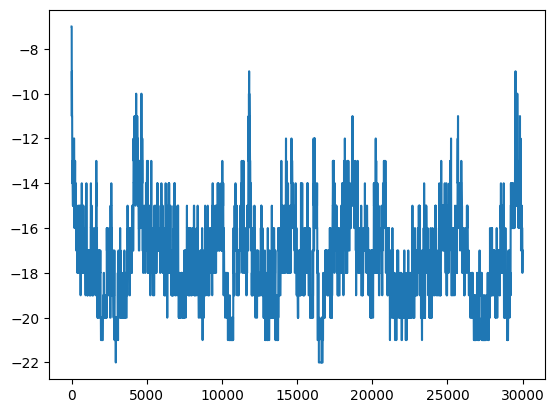

In [118]:
plt.plot(ts, energies)